## DATA 620 - Project 2: Marvel Social Network Universe

**By Eddie Xu and Mohamed Hassan-El Serafi**

For this project:

Instructions:

Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?
You may work in a small group on the project.

Your code and analysis should be delivered in an IPython Notebook by end of day Monday 

[Kaggle data link](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)

In [1]:
# load packages
import pandas as pd
import numpy as np
import networkx as nx
import random
import movecolumn as mc
from scipy import stats
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,10)

# import packages to set up bipartite graph and communities
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout
from community import community_louvain
import matplotlib.cm as cm
import networkx.algorithms.community as nx_comm

### Data Selection

In [2]:
edges_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/edges.csv'
network_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/hero-network.csv'
nodes_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/nodes.csv' 

# extract data
nodes_raw = pd.read_csv(nodes_url)
edges_raw = pd.read_csv(edges_url)
network_raw = pd.read_csv(network_url)

### Exploratory Data Analysis

In [3]:
# Setting seed
random.seed(42)

#### Nodes

In [4]:
nodes_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node    19090 non-null  object
 1   type    19090 non-null  object
dtypes: object(2)
memory usage: 298.4+ KB


In [5]:
nodes_raw.head(10)

node   type
0               2001 10  comic
1                2001 8  comic
2                2001 9  comic
3  24-HOUR MAN/EMMANUEL   hero
4  3-D MAN/CHARLES CHAN   hero
5      4-D MAN/MERCURIO   hero
6               8-BALL/   hero
7                 A '00  comic
8                 A '01  comic
9                 A 100  comic

In [6]:
nodes_profile = ProfileReport(nodes_raw, title="Nodes Profiling Report")
nodes_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Edges

In [7]:
edges_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero    96104 non-null  object
 1   comic   96104 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [8]:
edges_raw.head(10)

hero     comic
0  24-HOUR MAN/EMMANUEL    AA2 35
1  3-D MAN/CHARLES CHAN     AVF 4
2  3-D MAN/CHARLES CHAN     AVF 5
3  3-D MAN/CHARLES CHAN     COC 1
4  3-D MAN/CHARLES CHAN    H2 251
5  3-D MAN/CHARLES CHAN    H2 252
6  3-D MAN/CHARLES CHAN  M/PRM 35
7  3-D MAN/CHARLES CHAN  M/PRM 36
8  3-D MAN/CHARLES CHAN  M/PRM 37
9  3-D MAN/CHARLES CHAN     WI? 9

In [9]:
edges_profile = ProfileReport(edges_raw, title="Edges Profiling Report")
edges_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Network

In [10]:
network_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [11]:
network_raw.head(10)

hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL
5  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
6  STEELE, SIMON/WOLFGA      FORTUNE, DOMINIC
7  STEELE, SIMON/WOLFGA   ERWIN, CLYTEMNESTRA
8  STEELE, SIMON/WOLFGA  IRON MAN/TONY STARK 
9  STEELE, SIMON/WOLFGA  IRON MAN IV/JAMES R.

In [12]:
network_profile = ProfileReport(network_raw, title="Network Profiling Report")
network_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Transformation

#### Sample

In [13]:
# For unipartite graph
# create the hero network
random.seed(42)
Thor_network = network_raw[network_raw['hero1'].str.contains('THOR/DR. DONALD BLAK')].sample(100)
Cap_network = network_raw[network_raw['hero1'].str.contains('CAPTAIN AMERICA')].sample(100)
IronMan_network = network_raw[network_raw['hero1'].str.contains('IRON MAN/TONY STARK')].sample(100)
BlackWidow_network = network_raw[network_raw['hero1'].str.contains('BLACK WIDOW/NATASHA')].sample(100)
Hulk_network = network_raw[network_raw['hero1'].str.contains('HULK/DR. ROBERT BRUC')].sample(100)

# combine all avenger networks into one
network_subset = pd.concat([Thor_network, Cap_network, IronMan_network, BlackWidow_network, Hulk_network],axis = 0)

# save csv
# network_subset.to_csv('Resources/network_subset.csv', index=False)

In [40]:
## for bipartite graph
# create the avenger list
random.seed(42)
avenger_list = ['THOR/DR. DONALD BLAK', 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'BLACK WIDOW/NATASHA', 'HULK/DR. ROBERT BRUC']

# extract edges of original avengers except for hawkeyes as there is no data for it
Thor_edge = edges_raw[edges_raw['hero'].str.contains('THOR/DR. DONALD BLAK')].sample(100)
Cap_edge = edges_raw[edges_raw['hero'].str.contains('CAPTAIN AMERICA')].sample(100)
IronMan_edge = edges_raw[edges_raw['hero'].str.contains('IRON MAN/TONY STARK')].sample(100)
BlackWidow_edge = edges_raw[edges_raw['hero'].str.contains('BLACK WIDOW/NATASHA')].sample(100)
Hulk_edge = edges_raw[edges_raw['hero'].str.contains('HULK/DR. ROBERT BRUC')].sample(100)

# combine all avenger edges into one
edge_subset = pd.concat([Thor_edge, Cap_edge, IronMan_edge, BlackWidow_edge, Hulk_edge],axis = 0)
edge_list = pd.DataFrame(list(zip(edge_subset['hero'], edge_subset['comic'])),columns=['hero', 'comic'])
print(edge_list)
# create the comic list
# comic_list = edge_subset['comic']

# save csv
# edge_list.to_csv('Resources/edge_list.csv', index=False)
# comic_list.to_csv('Resources/comic_list.csv', index=False)

                     hero     comic
0    THOR/DR. DONALD BLAK     A 229
1    THOR/DR. DONALD BLAK    HR:R 1
2    THOR/DR. DONALD BLAK     T 400
3    THOR/DR. DONALD BLAK  PPSM2 11
4    THOR/DR. DONALD BLAK     T 300
..                    ...       ...
495  HULK/DR. ROBERT BRUC    H2 365
496  HULK/DR. ROBERT BRUC    H2 341
497  HULK/DR. ROBERT BRUC    H2 152
498  HULK/DR. ROBERT BRUC    H2 419
499  HULK/DR. ROBERT BRUC    XM '98

[500 rows x 2 columns]


### Network Analysis

#### Unipartite Network

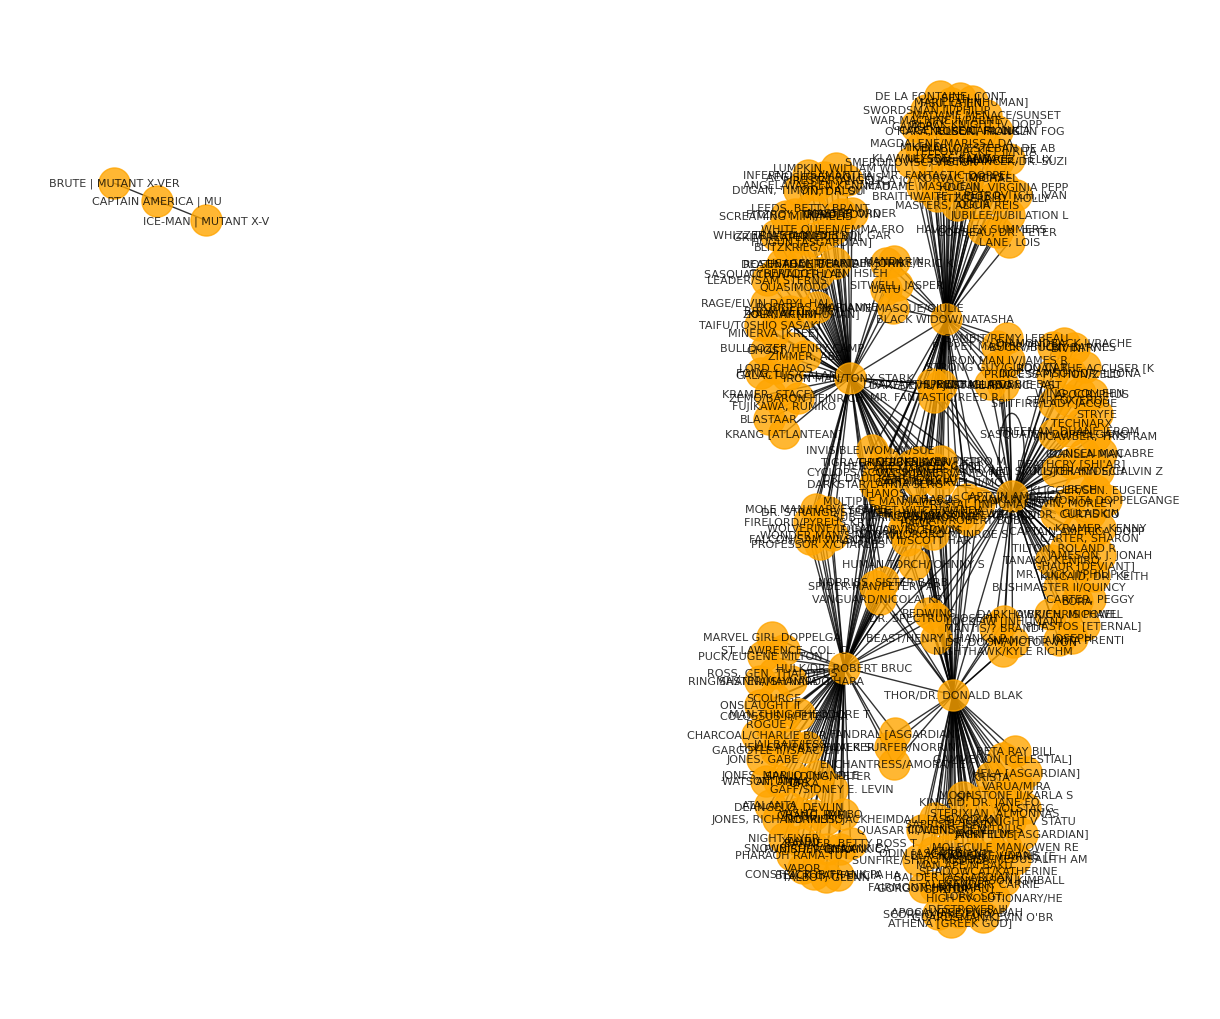

In [15]:
avenger_network_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/network_subset.csv'
avenger_network = pd.read_csv(avenger_network_url)

G=nx.from_pandas_edgelist(avenger_network, 'hero1', 'hero2')
pos = nx.spring_layout(G, seed=648)  # Seed layout for reproducible node positions
nx.draw(G, pos, with_labels=True, node_size=500, node_color="orange", font_size=8, font_color="black", edge_color="black", alpha=0.8)

plt.show()

## Network Centrality

### Degree Centrality

In [16]:
# get the degree centrality
random.seed(42)
avenger_centrality = nx.degree_centrality(G)
sorted_avenger_centrality = sorted(avenger_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Degree Centrality:", sorted_avenger_centrality)
sorted_avenger_centrality

Top Avenger by Degree Centrality: [('IRON MAN/TONY STARK ', 0.2973977695167286), ('CAPTAIN AMERICA', 0.2936802973977695), ('BLACK WIDOW/NATASHA ', 0.2788104089219331), ('HULK/DR. ROBERT BRUC', 0.275092936802974), ('THOR/DR. DONALD BLAK', 0.2639405204460966), ('HAWK', 0.018587360594795536), ('VISION ', 0.018587360594795536), ('JARVIS, EDWIN ', 0.018587360594795536), ('SCARLET WITCH/WANDA ', 0.018587360594795536), ('WASP/JANET VAN DYNE ', 0.01486988847583643)]


[('IRON MAN/TONY STARK ', 0.2973977695167286),
 ('CAPTAIN AMERICA', 0.2936802973977695),
 ('BLACK WIDOW/NATASHA ', 0.2788104089219331),
 ('HULK/DR. ROBERT BRUC', 0.275092936802974),
 ('THOR/DR. DONALD BLAK', 0.2639405204460966),
 ('HAWK', 0.018587360594795536),
 ('VISION ', 0.018587360594795536),
 ('JARVIS, EDWIN ', 0.018587360594795536),
 ('SCARLET WITCH/WANDA ', 0.018587360594795536),
 ('WASP/JANET VAN DYNE ', 0.01486988847583643)]

In [17]:
avenger_degree_df = pd.DataFrame(sorted(avenger_centrality.items(), key=lambda x: x[1], reverse=True), 
                               columns=['Name', 'Degree Centrality'])

# top 10
avenger_degree_df.head(10)

Name  Degree Centrality
0  IRON MAN/TONY STARK            0.297398
1       CAPTAIN AMERICA           0.293680
2  BLACK WIDOW/NATASHA            0.278810
3  HULK/DR. ROBERT BRUC           0.275093
4  THOR/DR. DONALD BLAK           0.263941
5                  HAWK           0.018587
6               VISION            0.018587
7        JARVIS, EDWIN            0.018587
8  SCARLET WITCH/WANDA            0.018587
9  WASP/JANET VAN DYNE            0.014870

In [18]:
# bottom 10
avenger_degree_df.tail(10)

Name  Degree Centrality
260                VASHTI           0.003717
261  GAFF/SIDNEY E. LEVIN           0.003717
262  ROSS, GEN. THADDEUS            0.003717
263      SPAULDING, PETER           0.003717
264              ATALANTA           0.003717
265          WATSON, ANNA           0.003717
266         JAILBAIT/JESS           0.003717
267      PHARAOH RAMA-TUT           0.003717
268                  ORKA           0.003717
269  CONSTRICTOR/FRANK PA           0.003717

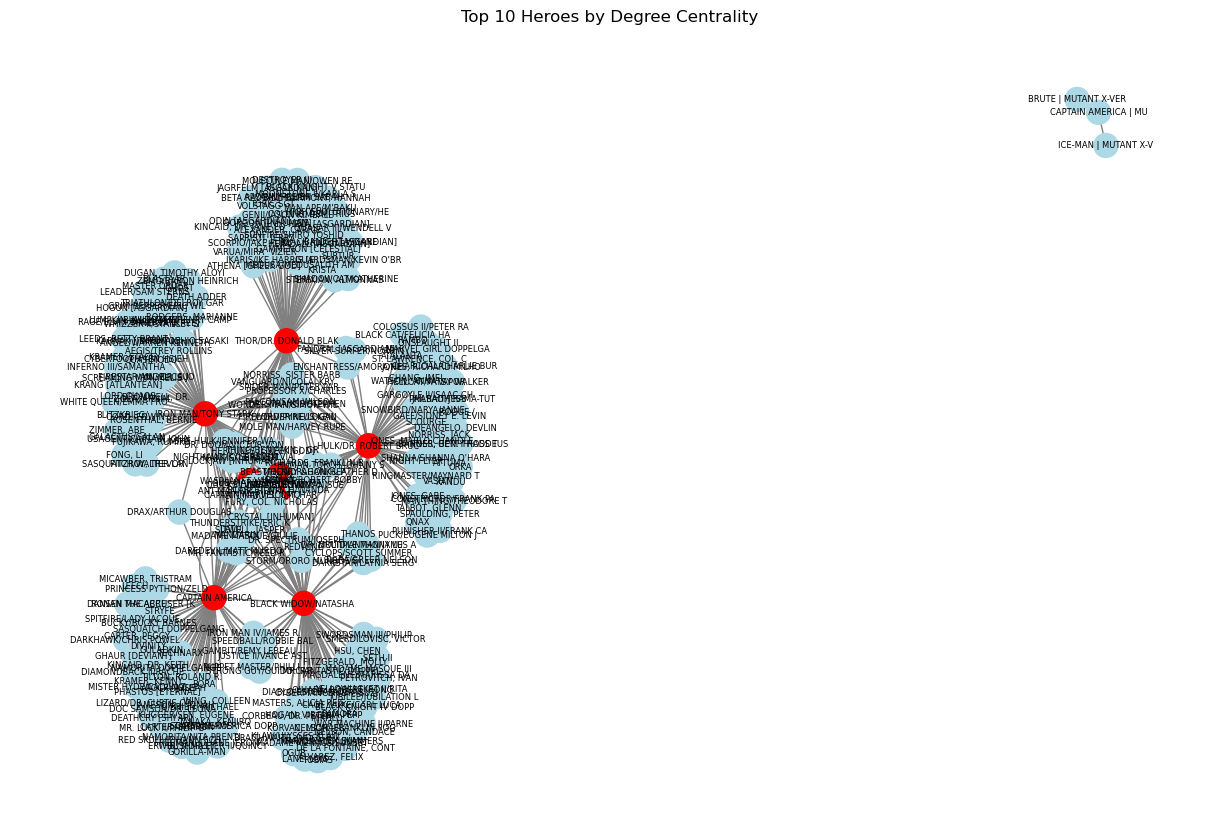

In [19]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes1 = [node for node, _ in sorted_avenger_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes1 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Degree Centrality")
plt.show()

### Betweenness Centrality

In [20]:
# get the betweeness centrality
random.seed(42)
avenger_betweeness_centrality = nx.betweenness_centrality(G)
sorted_betweeness_centrality = sorted(avenger_betweeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Betweeness Centrality:", sorted_betweeness_centrality)
sorted_betweeness_centrality

Top Avenger by Betweeness Centrality: [('CAPTAIN AMERICA', 0.3478069028199432), ('IRON MAN/TONY STARK ', 0.3373081485826295), ('THOR/DR. DONALD BLAK', 0.31706840201541586), ('HULK/DR. ROBERT BRUC', 0.30593315948140354), ('BLACK WIDOW/NATASHA ', 0.29421453539525), ('HAWK', 0.005557184866955717), ('VISION ', 0.005557184866955717), ('JARVIS, EDWIN ', 0.005557184866955717), ('SCARLET WITCH/WANDA ', 0.005557184866955717), ('INVISIBLE WOMAN/SUE ', 0.005557184866955717)]


[('CAPTAIN AMERICA', 0.3478069028199432),
 ('IRON MAN/TONY STARK ', 0.3373081485826295),
 ('THOR/DR. DONALD BLAK', 0.31706840201541586),
 ('HULK/DR. ROBERT BRUC', 0.30593315948140354),
 ('BLACK WIDOW/NATASHA ', 0.29421453539525),
 ('HAWK', 0.005557184866955717),
 ('VISION ', 0.005557184866955717),
 ('JARVIS, EDWIN ', 0.005557184866955717),
 ('SCARLET WITCH/WANDA ', 0.005557184866955717),
 ('INVISIBLE WOMAN/SUE ', 0.005557184866955717)]

In [21]:
avenger_betweenness_df = pd.DataFrame(sorted(avenger_betweeness_centrality.items(), key=lambda x: x[1], reverse=True), 
                               columns=['Name', 'Betweenness Centrality'])

# top 10
avenger_betweenness_df.head(10)

Name  Betweenness Centrality
0       CAPTAIN AMERICA                0.347807
1  IRON MAN/TONY STARK                 0.337308
2  THOR/DR. DONALD BLAK                0.317068
3  HULK/DR. ROBERT BRUC                0.305933
4  BLACK WIDOW/NATASHA                 0.294215
5                  HAWK                0.005557
6               VISION                 0.005557
7        JARVIS, EDWIN                 0.005557
8  SCARLET WITCH/WANDA                 0.005557
9  INVISIBLE WOMAN/SUE                 0.005557

In [22]:
# Bottom 10
avenger_betweenness_df.tail(10)

Name  Betweenness Centrality
260                VASHTI                     0.0
261  GAFF/SIDNEY E. LEVIN                     0.0
262  ROSS, GEN. THADDEUS                      0.0
263      SPAULDING, PETER                     0.0
264              ATALANTA                     0.0
265          WATSON, ANNA                     0.0
266         JAILBAIT/JESS                     0.0
267      PHARAOH RAMA-TUT                     0.0
268                  ORKA                     0.0
269  CONSTRICTOR/FRANK PA                     0.0

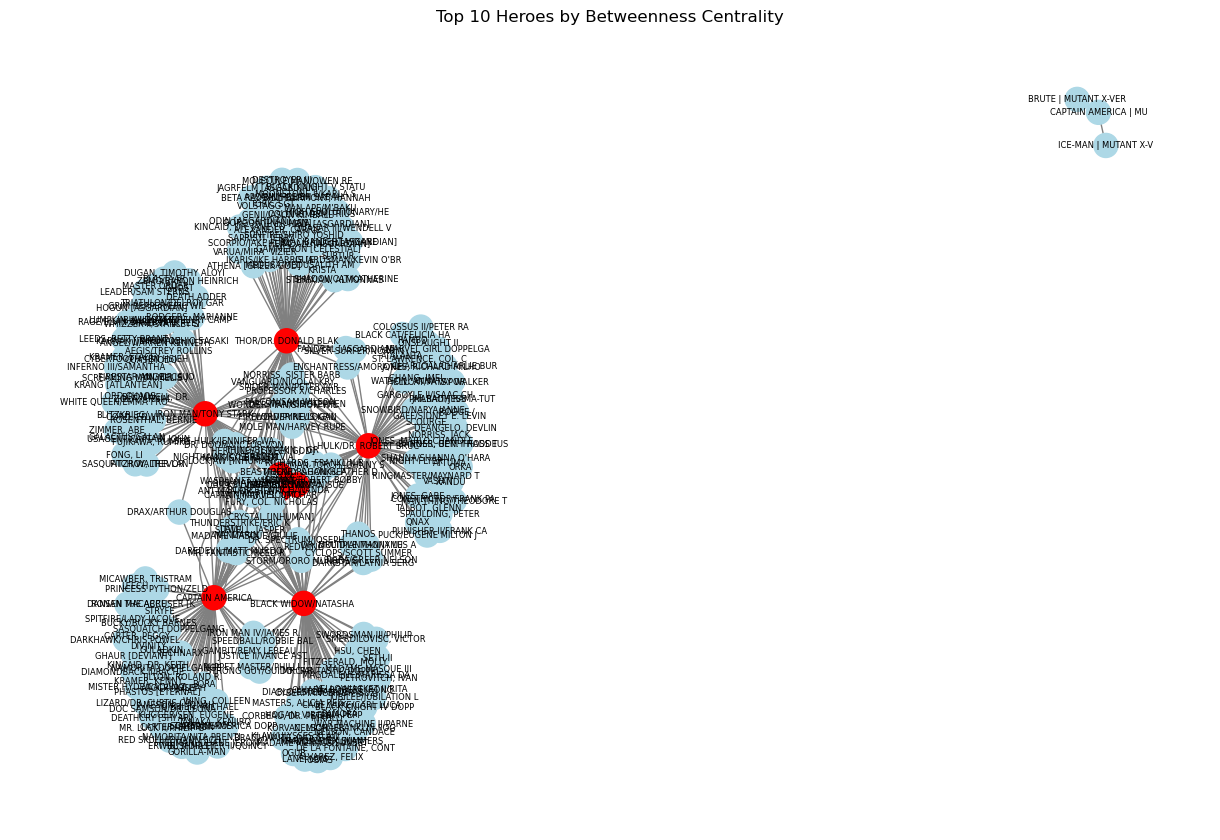

In [23]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes2 = [node for node, _ in sorted_betweeness_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes2 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Betweenness Centrality")
plt.show()

### Closeness Centrality

In [24]:
# get the closenss centrality
random.seed(42)
avenger_closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(avenger_closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Closeness Centrality:", sorted_closeness_centrality)
sorted_closeness_centrality

Top Avenger by Closeness Centrality: [('CAPTAIN AMERICA', 0.5780955104375178), ('THOR/DR. DONALD BLAK', 0.570571490778895), ('IRON MAN/TONY STARK ', 0.5346208480672167), ('BLACK WIDOW/NATASHA ', 0.5292423687104036), ('HAWK', 0.4991147196377052), ('VISION ', 0.4991147196377052), ('JARVIS, EDWIN ', 0.4991147196377052), ('SCARLET WITCH/WANDA ', 0.4991147196377052), ('HULK/DR. ROBERT BRUC', 0.48619862707776457), ('WASP/JANET VAN DYNE ', 0.4630870726216032)]


[('CAPTAIN AMERICA', 0.5780955104375178),
 ('THOR/DR. DONALD BLAK', 0.570571490778895),
 ('IRON MAN/TONY STARK ', 0.5346208480672167),
 ('BLACK WIDOW/NATASHA ', 0.5292423687104036),
 ('HAWK', 0.4991147196377052),
 ('VISION ', 0.4991147196377052),
 ('JARVIS, EDWIN ', 0.4991147196377052),
 ('SCARLET WITCH/WANDA ', 0.4991147196377052),
 ('HULK/DR. ROBERT BRUC', 0.48619862707776457),
 ('WASP/JANET VAN DYNE ', 0.4630870726216032)]

In [25]:
avenger_closeness_df = pd.DataFrame(sorted(avenger_closeness_centrality.items(), key=lambda x: x[1], reverse=True), 
                               columns=['Name', 'Closeness Centrality'])

# top 10
avenger_closeness_df.head(10)

Name  Closeness Centrality
0       CAPTAIN AMERICA              0.578096
1  THOR/DR. DONALD BLAK              0.570571
2  IRON MAN/TONY STARK               0.534621
3  BLACK WIDOW/NATASHA               0.529242
4                  HAWK              0.499115
5               VISION               0.499115
6        JARVIS, EDWIN               0.499115
7  SCARLET WITCH/WANDA               0.499115
8  HULK/DR. ROBERT BRUC              0.486199
9  WASP/JANET VAN DYNE               0.463087

In [26]:
# Bottom 10
avenger_closeness_df.tail(10)

Name  Closeness Centrality
260      SPAULDING, PETER              0.326344
261              ATALANTA              0.326344
262          WATSON, ANNA              0.326344
263         JAILBAIT/JESS              0.326344
264      PHARAOH RAMA-TUT              0.326344
265                  ORKA              0.326344
266  CONSTRICTOR/FRANK PA              0.326344
267  CAPTAIN AMERICA | MU              0.007435
268  ICE-MAN | MUTANT X-V              0.004957
269  BRUTE | MUTANT X-VER              0.004957

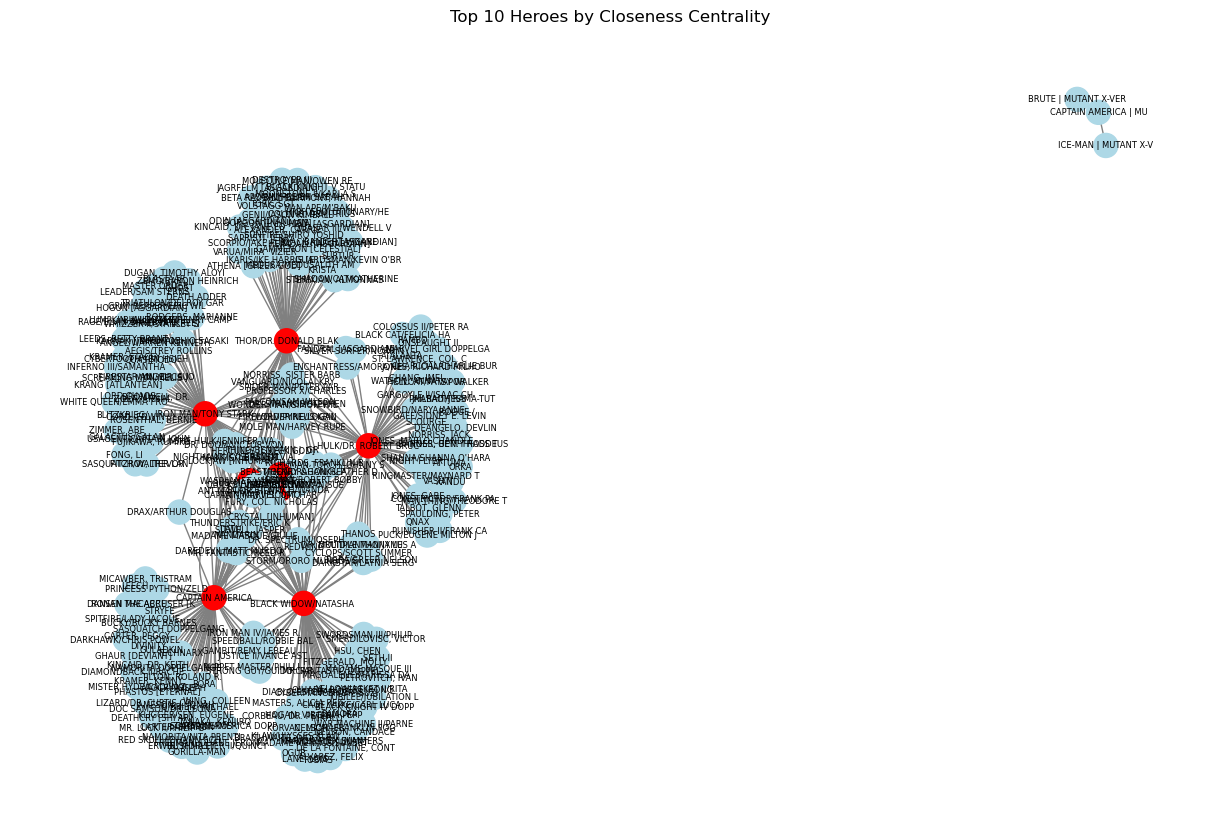

In [27]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes3 = [node for node, _ in sorted_closeness_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes3 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Closeness Centrality")
plt.show()

### Eigenvector Centrality

In [28]:
random.seed(42)
avenger_eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(avenger_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Eigenvector Centrality:", sorted_eigenvector_centrality)
sorted_eigenvector_centrality

Top Avenger by Eigenvector Centrality: [('CAPTAIN AMERICA', 0.3909241091533256), ('IRON MAN/TONY STARK ', 0.3525811852449677), ('BLACK WIDOW/NATASHA ', 0.34133169008082104), ('THOR/DR. DONALD BLAK', 0.33444984081804374), ('HULK/DR. ROBERT BRUC', 0.2658943323961009), ('HAWK', 0.12544344909694233), ('VISION ', 0.12544344909694233), ('JARVIS, EDWIN ', 0.12544344909694233), ('SCARLET WITCH/WANDA ', 0.12544344909694233), ('WASP/JANET VAN DYNE ', 0.10565032005460415)]


[('CAPTAIN AMERICA', 0.3909241091533256),
 ('IRON MAN/TONY STARK ', 0.3525811852449677),
 ('BLACK WIDOW/NATASHA ', 0.34133169008082104),
 ('THOR/DR. DONALD BLAK', 0.33444984081804374),
 ('HULK/DR. ROBERT BRUC', 0.2658943323961009),
 ('HAWK', 0.12544344909694233),
 ('VISION ', 0.12544344909694233),
 ('JARVIS, EDWIN ', 0.12544344909694233),
 ('SCARLET WITCH/WANDA ', 0.12544344909694233),
 ('WASP/JANET VAN DYNE ', 0.10565032005460415)]

In [29]:
avenger_eigenvector_df = pd.DataFrame(sorted(avenger_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True), 
                               columns=['Name', 'Eigenvector Centrality'])

# top 10
avenger_eigenvector_df.head(10)

Name  Eigenvector Centrality
0       CAPTAIN AMERICA                0.390924
1  IRON MAN/TONY STARK                 0.352581
2  BLACK WIDOW/NATASHA                 0.341332
3  THOR/DR. DONALD BLAK                0.334450
4  HULK/DR. ROBERT BRUC                0.265894
5                  HAWK                0.125443
6               VISION                 0.125443
7        JARVIS, EDWIN                 0.125443
8  SCARLET WITCH/WANDA                 0.125443
9  WASP/JANET VAN DYNE                 0.105650

In [30]:
# bottom 10
avenger_eigenvector_df.tail(10)

Name  Eigenvector Centrality
260      SPAULDING, PETER            1.979313e-02
261              ATALANTA            1.979313e-02
262          WATSON, ANNA            1.979313e-02
263         JAILBAIT/JESS            1.979313e-02
264      PHARAOH RAMA-TUT            1.979313e-02
265                  ORKA            1.979313e-02
266  CONSTRICTOR/FRANK PA            1.979313e-02
267  CAPTAIN AMERICA | MU            7.217208e-22
268  ICE-MAN | MUTANT X-V            5.103336e-22
269  BRUTE | MUTANT X-VER            5.103336e-22

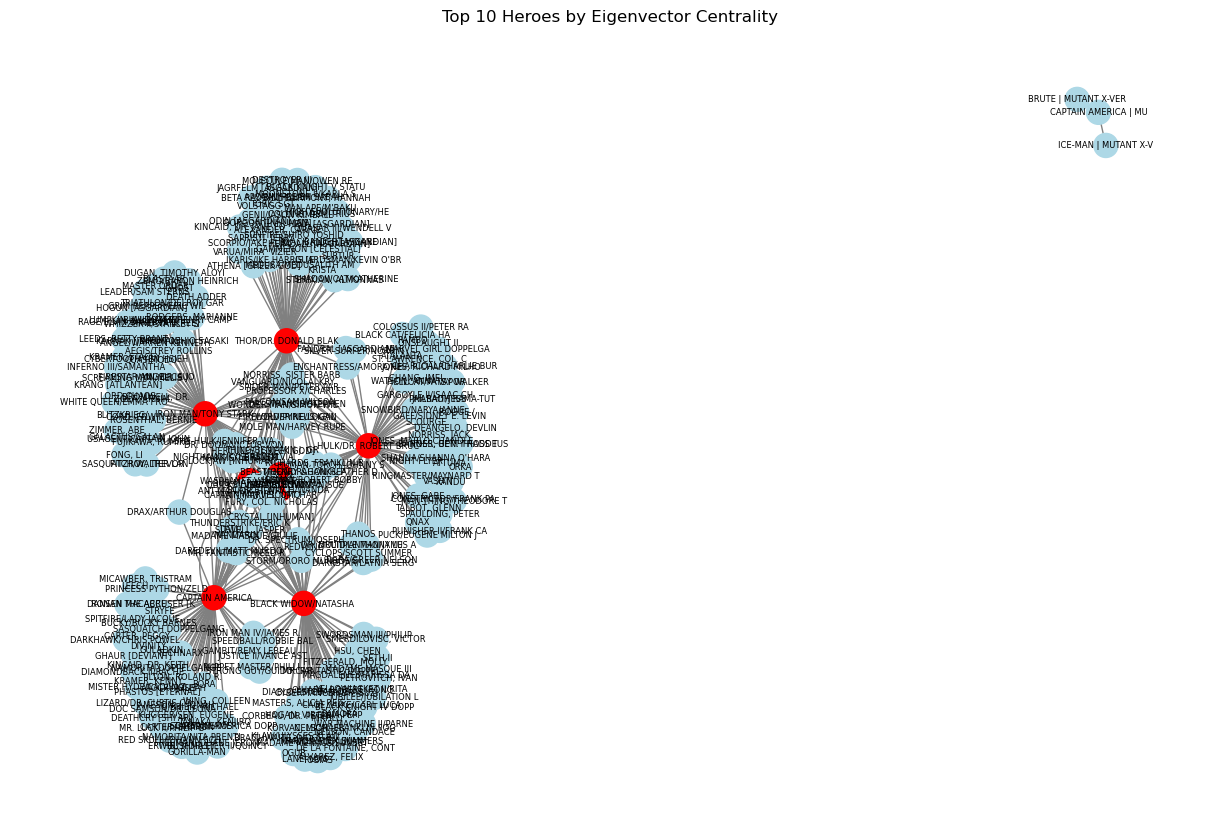

In [31]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes4 = [node for node, _ in sorted_eigenvector_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes4 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Eigenvector Centrality")
plt.show()

#### Bipartite Network

In [44]:
# extract data
avenger_edge_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/edge_list.csv'
avenger_comic_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/comic_list.csv'

avenger_edge = pd.read_csv(avenger_edge_url)
avenger_edge_list = list(avenger_edge[['hero', 'comic']].apply(tuple, axis=1))
avenger_comic = pd.read_csv(avenger_comic_url)
avenger_comic_list = list(avenger_comic['comic'])
avenger_comic

comic
0    WOSM 75
1    T 144/2
2       A 95
3      T 287
4      A 310
..       ...
495   H2 339
496   H2 367
497   H2 368
498     HS 1
499   H2 438

[500 rows x 1 columns]

In [43]:
print(avenger_list)

['THOR/DR. DONALD BLAK', 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'BLACK WIDOW/NATASHA', 'HULK/DR. ROBERT BRUC']


In [33]:
# create the bipartite graph
avenger_bipart = nx.Graph()

# add nodes and edges
avenger_bipart.add_nodes_from(avenger_comic_list, bipartite=0)
avenger_bipart.add_nodes_from(avenger_list, bipartite=1)
avenger_bipart.add_edges_from(avenger_edge_list)

# check if the graph is bipartite
print(bipartite.is_bipartite(avenger_bipart)) 

bipartite_none = list()
# Examine the bipartite attribute of each node
for node, data in avenger_bipart.nodes(data=True):
    if data.get('bipartite') == None:
        print(f"Node {node}: bipartite = {data.get('bipartite')}")
        bipartite_none.append(node)

True
Node T 347: bipartite = None
Node T 191: bipartite = None
Node T 313: bipartite = None
Node T 315: bipartite = None
Node T 251: bipartite = None
Node T 282: bipartite = None
Node T 290: bipartite = None
Node A 82: bipartite = None
Node N 13: bipartite = None
Node T 477: bipartite = None
Node A 309: bipartite = None
Node GAL 3: bipartite = None
Node T 333: bipartite = None
Node FF 150: bipartite = None
Node JIM 100/2: bipartite = None
Node A 149: bipartite = None
Node T 308: bipartite = None
Node A3 2: bipartite = None
Node T 176: bipartite = None
Node M/TU 11: bipartite = None
Node COC 1: bipartite = None
Node T 335: bipartite = None
Node FF2 12: bipartite = None
Node JIM 116/2: bipartite = None
Node T2 27: bipartite = None
Node A 292: bipartite = None
Node T2 18: bipartite = None
Node T 181: bipartite = None
Node T 475: bipartite = None
Node T 375: bipartite = None
Node A 45: bipartite = None
Node PPTSS 170: bipartite = None
Node T2 35: bipartite = None
Node T 278: bipartite = No

In [34]:
# remove nodes that have NONE bipartite
avenger_bipart.remove_nodes_from(bipartite_none)

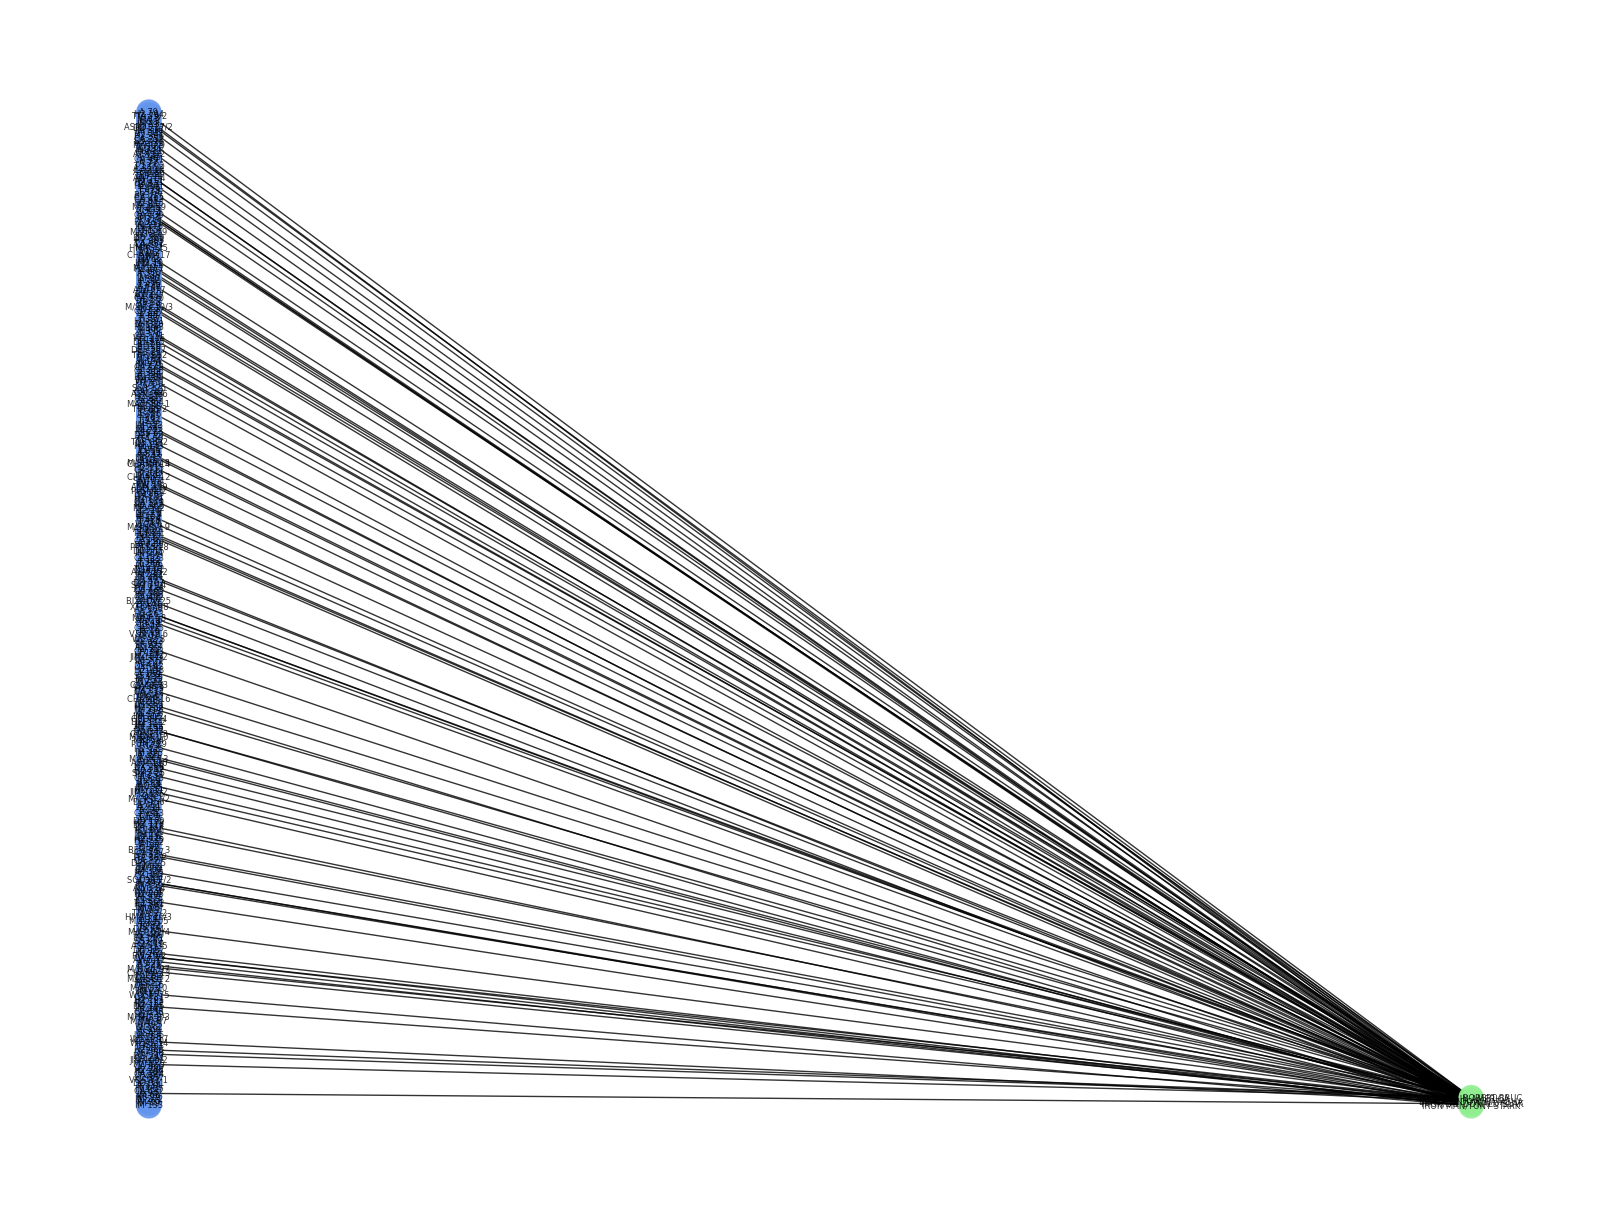

In [45]:
# separate nodes
top_nodes_subset = {n for n, d in avenger_bipart.nodes(data=True) if d['bipartite'] == 0}
bottom_nodes_subset = {n for n, d in avenger_bipart.nodes(data=True) if d['bipartite'] == 1}
avenger_bipart.nodes(data=True)

# set node colors
color_dict = {0:'cornflowerblue', 1:'lightgreen'}
color_list = [color_dict[i[1]] for i in avenger_bipart.nodes.data('bipartite')]

# draw a bipartite graph
pos = dict()
color = []

pos.update((n, (1, i)) for i, n in enumerate(top_nodes_subset)) 
pos.update((n, (2, i)) for i, n in enumerate(bottom_nodes_subset)) 
plt.figure(figsize=(16, 12))
nx.draw(avenger_bipart, pos=pos, with_labels=True, node_color=color_list, font_size=6, alpha=0.8)
plt.show()

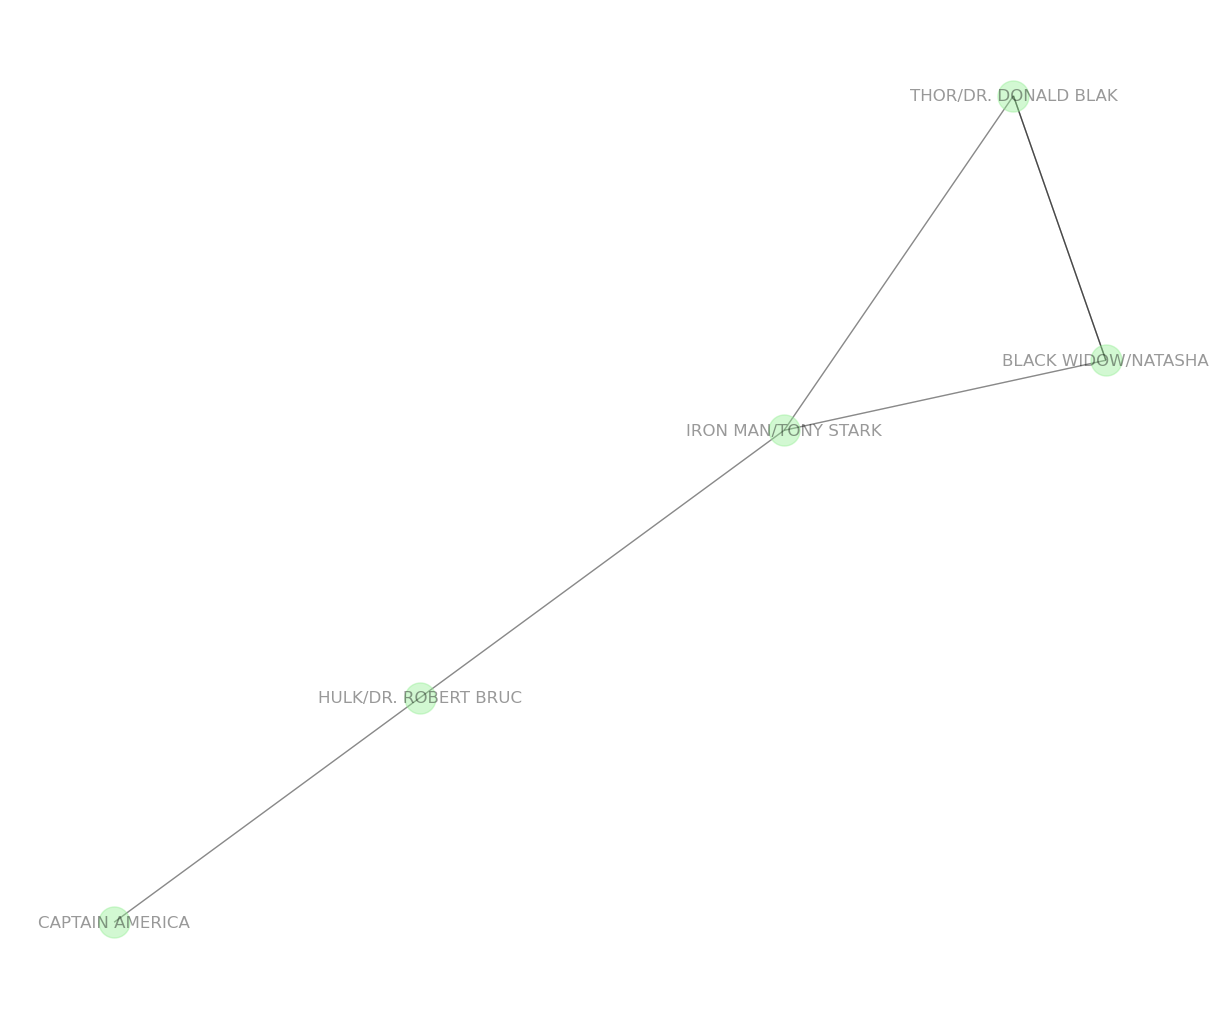

In [36]:
avenger_graph = bipartite.projected_graph(avenger_bipart, avenger_list, multigraph=True)

pos=nx.spring_layout(avenger_graph)
nx.draw(avenger_graph, pos=pos, node_size=500, with_labels = True, node_color='lightgreen', alpha=0.4)
nx.draw_networkx_edges(avenger_graph, pos=pos, alpha=0.1)

plt.show()

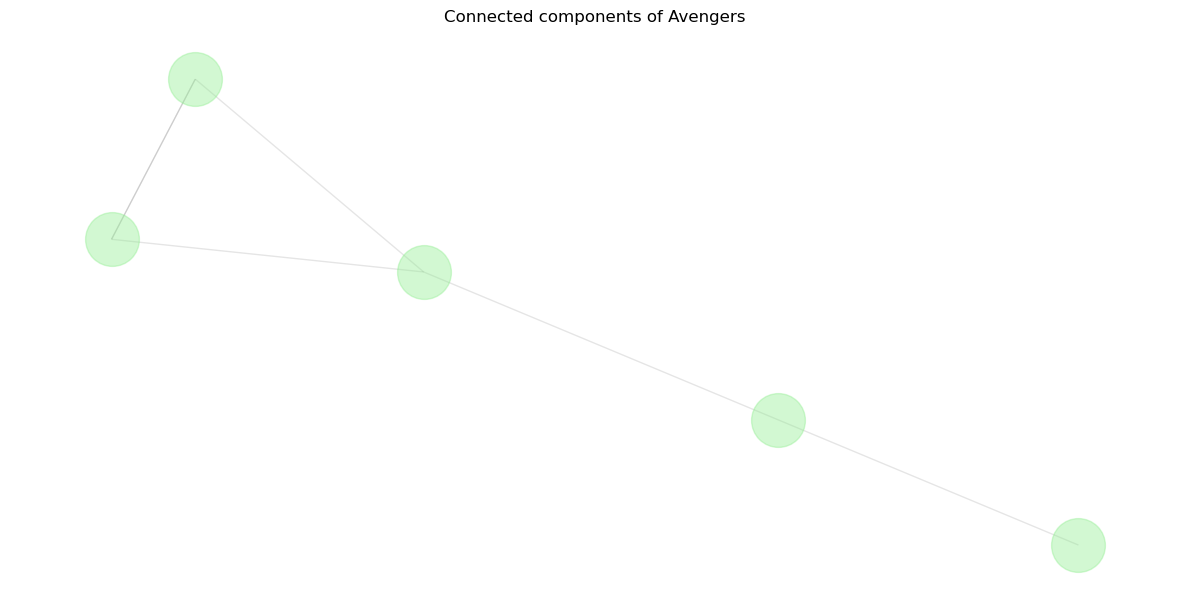

In [37]:
# Ranking of nodes regarding the number of degrees
degree_sequence = sorted([d for n, d in avenger_graph.degree()], reverse=True)

# Extract connected nodes to visualize
Gcc = avenger_graph.subgraph(sorted(nx.connected_components(avenger_graph), key=len, reverse=True)[0])

# Visualization
fig = plt.figure("Degree of the avenger graph")
axgrid = fig.add_gridspec(5, 4)
ax0 = fig.add_subplot(axgrid[0:3, :])
pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=1500, alpha=0.4, node_color='lightgreen')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
ax0.set_title("Connected components of Avengers")
ax0.set_axis_off()

fig.tight_layout()
plt.show()

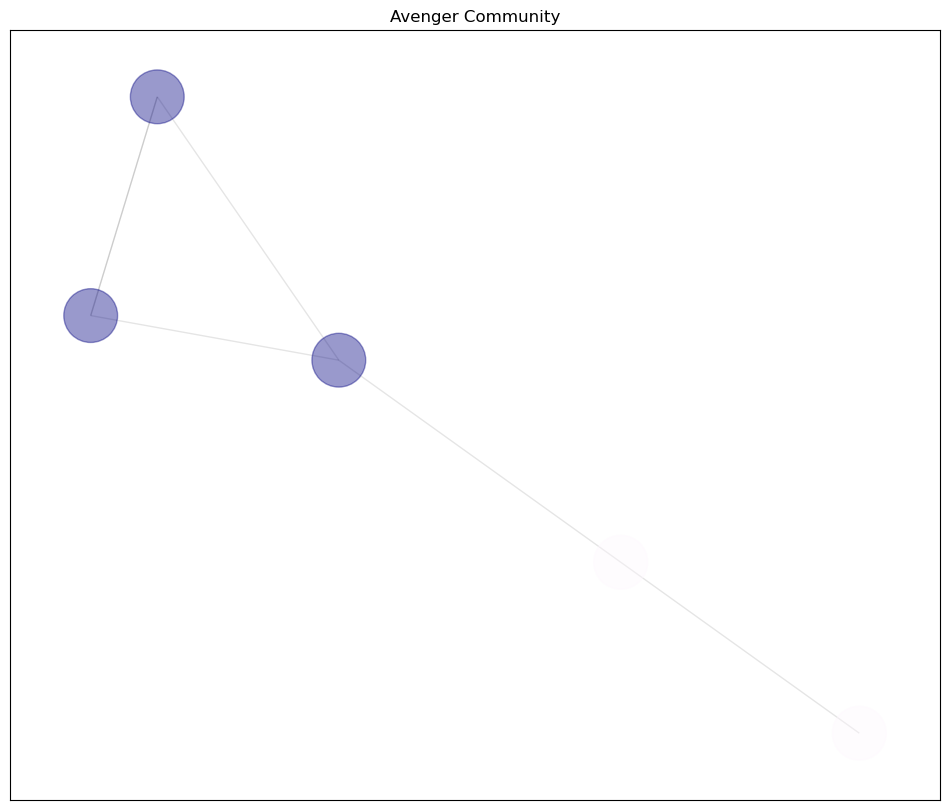

In [38]:
# Community division
partition_avenger = community_louvain.best_partition(Gcc)

# Color the nodes according to community
cmap = cm.get_cmap('gist_ncar', max(partition_avenger.values()) + 1)

pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, partition_avenger.keys(), node_size=1500, alpha=0.4,
                       cmap=cmap, node_color=list(partition_avenger.values()))
nx.draw_networkx_edges(Gcc, pos, alpha=0.1)
plt.title("Avenger Community")
plt.show()

In [39]:
# find the modularity
avenger_modularity = nx_comm.modularity(avenger_graph, nx_comm.label_propagation_communities(avenger_graph))
print(f'Modularity of Hero network: {avenger_modularity}')

Modularity of Hero network: 0.2083333333333333


## Key Insights & Observations

When analyzing the top 10 heroes among each centrality measure, a few noteworthy observations stick out. Captain America ranks first in betweenness, closeness and eigenvector centralities and second in degree centrality. His rankings indicates that he plays a prominent role in the amount of connections he has, how well-connected he is to other heroes that are also well-connected, and is a bridge between and close to other characters. He's essentially at the center of the Marvel universe. Additionally, Iron Man is ranked no lower than 3rd in each of the centrality measures, including first in degree centrality, which demonstrates his strong presence in the Marvel universe. This isn't totally surprising, since Captain America and Iron Man are popular comic book heroes and are often working together. Black Widow and Thor each ranked in the top 5 in each centrality measure, which indicates their influence in the Marvel universe. Black Widow is the only female superhero in the top 5 in each centrality measure. While The Hulk ranked in the top 5 in degree, betweenness, and eigevector centralities, he ranked 9th in closeness centrality, which is understandable considering that while he is strong he also has uncontrollable rage, which might affect how other heroes interact with him. 

Heroes that have the lowest centrality measures are not well known. Orka and Constrictor were the only characters that ranked in the bottom 5 in each centrality measure, which indicates that they aren't popular among marvel comicbook heroes. Both characters are know as villains in Marvel comics, so their lack of connections could be explained by how they are preceived. Brute and Ice Man were ranked in the bottom 3 in closeness and eigenvector centralities, but are not ranked in the bottom 10 in degree or betweenness centrality. Brute is considered a villain, while Ice Man is considered a superhero, so their similar rankings for each centrality measure worth further exploring in a future analysis. Their respective measures indicate that while each are different types of characters, they are both not well-connected to other well-connected characters, and do not have close access to other characters. 

For the bipartite analysis, it shows that original avengers appear to multiple comics multiple times. After putting them in a projected graph, the connection between all original avengers are shown. Interestingly, the modularity, which shows the density of each connection appears to be zero.